We set target vol to 10% per annum to ensure fair return (and bc it is also the case in the paper)
Without rescaling, a strategy with higher volatility would naturally dominate the P&L simply because it takes bigger bets. By scaling everything to 10% volatility, we equalize the risk budget. If one strategy makes more money than another after this scaling, it is because it is more efficient (higher Sharpe Ratio), not just riskier

Pool of Strategies: ['CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

--- Strategy Performance Statistics ---
              Ann. Mean  Ann. Vol    Sharpe
Naive          0.102182  0.105024  0.972935
Mean           0.082924  0.106092  0.781627
Volatility     0.106154  0.107024  0.991870
Sharpe         0.087026  0.107863  0.806817
Top-3          0.096361  0.112459  0.856851
Max Return     0.122489  0.144972  0.844914
Min Variance   0.106700  0.143205  0.745089


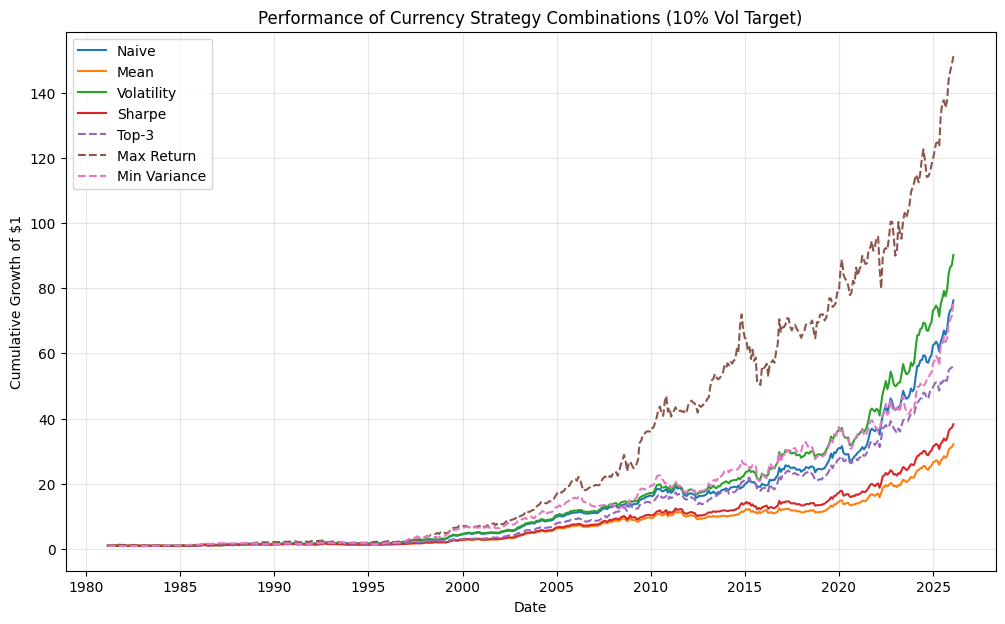

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize



df = pd.read_excel('../data/Factors_Net.xlsx')


if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df.set_index('date', inplace=True)


strategies = ['CAR', 'VAL', 'M1M', 'M3M',
                'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

# Filter for columns that actually exist in the file
available_strategies = [col for col in strategies if col in df.columns]
print(f"Pool of Strategies: {available_strategies}")

returns = df[available_strategies].dropna()
    
target_vol_ann = 0.10
target_vol_m = target_vol_ann / np.sqrt(12)
window = 60  # 5-year rolling window

# Storage
# We will store the *returns* of each combined strategy
combined_results = pd.DataFrame(index=returns.index[window:],
                                columns=['Naive', 'Mean', 'Volatility', 'Sharpe',
                                            'Top-3', 'Max Return', 'Min Variance'])

# Rolling Window Loop
for t in range(window, len(returns)):
    # Data available up to t-1
    past_returns = returns.iloc[t-window:t]

    # --- Inputs for Optimization ---
    mu = past_returns.mean()
    sigma = past_returns.cov()
    inv_sigma = np.linalg.pinv(sigma)  # Pseudo-inverse for stability
    vols = np.sqrt(np.diag(sigma))

    w_naive = np.ones(len(available_strategies)) / \
        len(available_strategies)

    # --- 2. Mean Combination ---
    w_mean = mu.values

    # --- 3. Volatility Combination (Inverse Vol) ---
    w_vol = 1.0 / vols

    # --- 4. Sharpe Combination (Heuristic) ---
    with np.errstate(divide='ignore', invalid='ignore'):
        w_sharpe_h = mu.values / vols
        w_sharpe_h[~np.isfinite(w_sharpe_h)] = 0.0

    # --- 5. Top-3 Combination ---
    # Calculate historical Sharpe for ranking
    hist_sharpe = mu / vols
    # Get indices of top 3
    top3_indices = hist_sharpe.nlargest(3).index
    # Create weight vector
    w_top3 = pd.Series(0.0, index=available_strategies)
    w_top3[top3_indices] = 1.0 / 3.0  # Equal weight to top 3
    w_top3 = w_top3.values

    # --- 6. Maximum Return (Mean-Variance) ---
    # Maximize Returns s.t. Vol = Target
    # Analytical solution: w proportional to Sigma^-1 * Mu
    w_maxret = inv_sigma @ mu.values

    # --- 7. Minimum Variance ---
    # Minimize Variance s.t. Sum(w)=1
    # Analytical solution: w proportional to Sigma^-1 * 1
    ones = np.ones(len(available_strategies))
    w_minvar = inv_sigma @ ones
    w_minvar = w_minvar / np.sum(w_minvar)  # Normalize to sum to 1

    # --- Volatility Scaling & Return Calculation ---
    # Apply scaling to ALL strategies to meet target volatility

    weight_dict = {
        'Naive': w_naive,
        'Mean': w_mean,
        'Volatility': w_vol,
        'Sharpe': w_sharpe_h,
        'Top-3': w_top3,
        'Max Return': w_maxret,
        'Min Variance': w_minvar
    }

    r_t = returns.iloc[t]  # Realized return for this month

    for name, w_raw in weight_dict.items():
        # Calculate ex-ante portfolio vol
        p_var = w_raw @ sigma @ w_raw.T
        p_vol = np.sqrt(p_var)

        # Scale weights
        if p_vol > 0:
            scaler = target_vol_m / p_vol
            w_final = w_raw * scaler
        else:
            w_final = w_raw

        # Store realized return
        combined_results.loc[returns.index[t],
                                name] = np.dot(w_final, r_t.values)

# 3. Statistics & Plotting
# ---------------------------------------------------------
combined_results = combined_results.apply(pd.to_numeric)

# Calculate Stats
def get_stats(series):
    ann_mean = series.mean() * 12
    ann_vol = series.std() * np.sqrt(12)
    sharpe = ann_mean / ann_vol if ann_vol != 0 else 0
    return pd.Series({'Ann. Mean': ann_mean, 'Ann. Vol': ann_vol, 'Sharpe': sharpe})

stats_df = combined_results.apply(get_stats)
print("\n--- Strategy Performance Statistics ---")
print(stats_df.T)  # Transpose for readability

# Plot
cumulative = (1 + combined_results).cumprod()

plt.figure(figsize=(12, 7))
for col in cumulative.columns:
    # Use dashed lines for the new strategies to distinguish
    style = '--' if col in ['Top-3', 'Max Return', 'Min Variance'] else '-'
    plt.plot(cumulative.index, cumulative[col], label=col, linestyle=style)

plt.title('Performance of Currency Strategy Combinations (10% Vol Target)')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth of $1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.covariance import LedoitWolf

# # 1. Load Data
# # ---------------------------------------------------------
# try:
#     df = pd.read_excel('../data/Factors_Net.xlsx')

#     # Parse dates
#     if 'date' in df.columns:
#         df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
#         df.set_index('date', inplace=True)

#     # Strategies to combine
#     strategies = ['CAR', 'VAL', 'M1M', 'M3M',
#                   'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']
#     available_strategies = [col for col in strategies if col in df.columns]
#     returns = df[available_strategies].dropna()

# except Exception as e:
#     print(f"Error loading data: {e}")
#     returns = pd.DataFrame()

# # 2. Strategy Logic
# # ---------------------------------------------------------
# if not returns.empty:
#     # Parameters
#     target_vol_ann = 0.10
#     target_vol_m = target_vol_ann / np.sqrt(12)
#     window = 60  # 5-year rolling window

#     # Storage
#     # We add 'Downside Parity' and 'Sortino' to the list
#     cols = ['Naive', 'Mean', 'Volatility', 'Sharpe', 'Top-3',
#             'Max Return', 'Min Variance', 'Downside Parity']
#     combined_results = pd.DataFrame(index=returns.index[window:], columns=cols)

#     # Rolling Window Loop
#     for t in range(window, len(returns)):
#         past_returns = returns.iloc[t-window:t]

#         # --- Standard Estimates ---
#         mu = past_returns.mean()

#         # Covariance (Ledoit-Wolf)
#         lw = LedoitWolf()
#         try:
#             lw.fit(past_returns)
#             sigma = lw.covariance_
#         except:
#             sigma = past_returns.cov().values

#         inv_sigma = np.linalg.pinv(sigma)
#         vols = np.sqrt(np.diag(sigma))

#         # --- Downside Estimates ---
#         # Calculate Semi-Deviation (std of negative returns only)
#         # If no negative returns, use a small epsilon to avoid division by zero
#         neg_rets = past_returns.copy()
#         neg_rets[neg_rets > 0] = 0
#         semi_vols = np.sqrt((neg_rets**2).mean())
#         semi_vols[semi_vols == 0] = 1e-6  # Safety

#         # --- 1. Naive (1/N) ---
#         w_naive = np.ones(len(available_strategies)) / \
#             len(available_strategies)

#         # --- 2. Mean ---
#         w_mean = mu.values

#         # --- 3. Volatility (Risk Parity) ---
#         w_vol = 1.0 / vols

#         # --- 4. Sharpe ---
#         with np.errstate(divide='ignore', invalid='ignore'):
#             w_sharpe = mu.values / vols
#             w_sharpe[~np.isfinite(w_sharpe)] = 0.0

#         # --- 5. Top-3 (Momentum) ---
#         hist_sharpe = mu / vols
#         top3_indices = hist_sharpe.nlargest(3).index
#         w_top3 = pd.Series(0.0, index=available_strategies)
#         idx_map = {name: i for i, name in enumerate(available_strategies)}
#         for name in top3_indices:
#             w_top3.iloc[idx_map[name]] = 1.0 / 3.0
#         w_top3 = w_top3.values

#         # --- 6. Max Return (MV) ---
#         w_maxret = inv_sigma @ mu.values

#         # --- 7. Min Variance ---
#         ones = np.ones(len(available_strategies))
#         w_minvar = inv_sigma @ ones
#         w_minvar = w_minvar / np.sum(w_minvar)

#         # --- 8. Downside Risk Parity (PROPOSED ALTERNATIVE) ---
#         # Weight proportional to 1 / Semi-Deviation
#         w_downside = 1.0 / semi_vols.values

#         # --- Volatility Scaling & Return Calculation ---
#         weight_dict = {
#             'Naive': w_naive,
#             'Mean': w_mean,
#             'Volatility': w_vol,
#             'Sharpe': w_sharpe,
#             'Top-3': w_top3,
#             'Max Return': w_maxret,
#             'Min Variance': w_minvar,
#             'Downside Parity': w_downside
#         }

#         r_t = returns.iloc[t]  # Realized return for this month

#         for name, w_raw in weight_dict.items():
#             # Ex-ante Portfolio Volatility (using full Sigma for scaling consistency)
#             # Note: Even for Downside Parity, we scale using standard Volatility
#             # to meet the "10% Vol Target" requirement of the paper exactly.
#             p_var = w_raw @ sigma @ w_raw.T
#             p_vol = np.sqrt(p_var)

#             # Scale
#             if p_vol > 0:
#                 scaler = target_vol_m / p_vol
#                 w_final = w_raw * scaler
#             else:
#                 w_final = w_raw

#             combined_results.loc[returns.index[t],
#                                  name] = np.dot(w_final, r_t.values)

#     # 3. Statistics & Plotting
#     # ---------------------------------------------------------
#     combined_results = combined_results.apply(pd.to_numeric)

#     def get_stats(series):
#         ann_mean = series.mean() * 12
#         ann_vol = series.std() * np.sqrt(12)
#         sharpe = ann_mean / ann_vol if ann_vol != 0 else 0
#         return pd.Series({'Ann. Mean': ann_mean, 'Ann. Vol': ann_vol, 'Sharpe': sharpe})

#     stats_df = combined_results.apply(get_stats)
#     print("\n--- Strategy Performance Statistics ---")
#     print(stats_df.T)

#     # Plot % Cumulative Growth
#     cumulative = (1 + combined_results).cumprod()
#     cumulative_pct = (cumulative - 1) * 100

#     plt.figure(figsize=(12, 7))
#     for col in cumulative_pct.columns:
#         # Highlight the new alternative
#         if col == 'Downside Parity':
#             plt.plot(cumulative_pct.index,
#                      cumulative_pct[col], label=col, color='black')
#         else:
#             style = '--' if col in ['Top-3',
#                                     'Max Return', 'Min Variance'] else '-'
#             plt.plot(cumulative_pct.index,
#                      cumulative_pct[col], label=col, linestyle=style, alpha=0.7)

#     plt.title('Performance Comparison Between All Strategies')
#     plt.xlabel('Date')
#     plt.ylabel('Cumulative Growth (%)')
#     plt.legend()
#     plt.grid(True, alpha=0.3)
#     plt.show()


--- Strategy Performance Statistics ---
                 Ann. Mean  Ann. Vol    Sharpe   Sortino
Naive             0.113373  0.115547  0.981191  1.686836
Mean              0.090220  0.122152  0.738585  1.201321
Volatility        0.117181  0.116455  1.006230  1.744993
Sharpe            0.090487  0.122420  0.739147  1.202521
Top-3             0.083305  0.118784  0.701317  1.141615
Max Return        0.103111  0.126681  0.813946  1.422867
Min Variance      0.105368  0.118310  0.890614  1.535126
Downside Parity   0.119694  0.119589  1.000883  1.732887


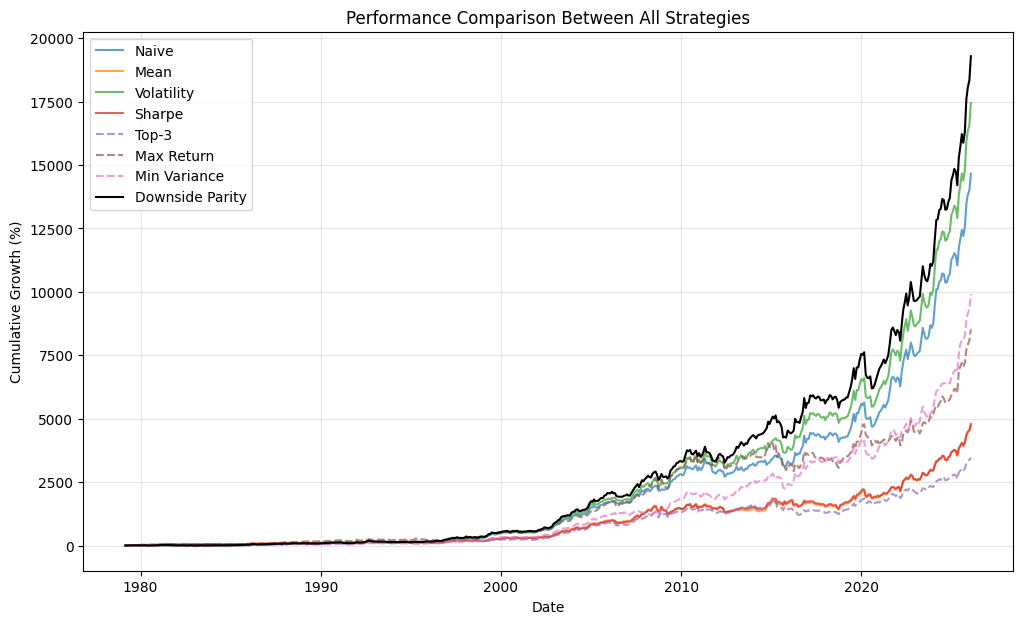

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# 1. Load Data
# ---------------------------------------------------------
try:
    df = pd.read_excel('../data/Factors_Net.xlsx')

    # Parse dates
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
        df.set_index('date', inplace=True)

    # Strategies to combine
    strategies = ['DOL', 'CAR', 'VAL', 'M1M', 'M3M',
                  'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']
    available_strategies = [col for col in strategies if col in df.columns]
    returns = df[available_strategies].dropna()

except Exception as e:
    print(f"Error loading data: {e}")
    returns = pd.DataFrame()

# 2. Strategy Logic
# ---------------------------------------------------------
if not returns.empty:
    # Parameters
    target_vol_ann = 0.10
    target_vol_m = target_vol_ann / np.sqrt(12)
    window = 36  # 3-year rolling window

    # Risk-free rate (CHANGE if needed)
    rf_ann = 0.0
    rf_m = rf_ann / 12

    # Storage
    cols = ['Naive', 'Mean', 'Volatility', 'Sharpe', 'Top-3',
            'Max Return', 'Min Variance', 'Downside Parity']
    combined_results = pd.DataFrame(index=returns.index[window:], columns=cols)

    # Rolling Window Loop
    for t in range(window, len(returns)):
        past_returns = returns.iloc[t-window:t]

        # --- Standard Estimates ---
        mu = past_returns.mean()

        # Covariance (Ledoit-Wolf)
        lw = LedoitWolf()
        try:
            lw.fit(past_returns)
            sigma = lw.covariance_
        except:
            sigma = past_returns.cov().values

        inv_sigma = np.linalg.pinv(sigma)
        vols = np.sqrt(np.diag(sigma))

        # --- Downside Estimates ---
        neg_rets = past_returns.copy()
        neg_rets[neg_rets > 0] = 0
        semi_vols = np.sqrt((neg_rets**2).mean())
        semi_vols[semi_vols == 0] = 1e-6

        # --- 1. Naive (1/N) ---
        w_naive = np.ones(len(available_strategies)) / \
            len(available_strategies)

        # --- 2. Mean ---
        w_mean = mu.values

        # --- 3. Volatility (Risk Parity) ---
        w_vol = 1.0 / vols

        # --- 4. Sharpe ---
        with np.errstate(divide='ignore', invalid='ignore'):
            w_sharpe = mu.values / vols
            w_sharpe[~np.isfinite(w_sharpe)] = 0.0

        # --- 5. Top-3 (Momentum) ---
        hist_sharpe = mu / vols
        top3_indices = hist_sharpe.nlargest(3).index
        w_top3 = pd.Series(0.0, index=available_strategies)
        idx_map = {name: i for i, name in enumerate(available_strategies)}
        for name in top3_indices:
            w_top3.iloc[idx_map[name]] = 1.0 / 3.0
        w_top3 = w_top3.values

        # --- 6. Max Return (MV) ---
        w_maxret = inv_sigma @ mu.values

        # --- 7. Min Variance ---
        ones = np.ones(len(available_strategies))
        w_minvar = inv_sigma @ ones
        w_minvar = w_minvar / np.sum(w_minvar)

        # --- 8. Downside Risk Parity ---
        w_downside = 1.0 / semi_vols.values

        # --- Volatility Scaling & Return Calculation ---
        weight_dict = {
            'Naive': w_naive,
            'Mean': w_mean,
            'Volatility': w_vol,
            'Sharpe': w_sharpe,
            'Top-3': w_top3,
            'Max Return': w_maxret,
            'Min Variance': w_minvar,
            'Downside Parity': w_downside
        }

        r_t = returns.iloc[t]

        for name, w_raw in weight_dict.items():
            p_var = w_raw @ sigma @ w_raw.T
            p_vol = np.sqrt(p_var)

            if p_vol > 0:
                scaler = target_vol_m / p_vol
                w_final = w_raw * scaler
            else:
                w_final = w_raw

            combined_results.loc[returns.index[t],
                                 name] = np.dot(w_final, r_t.values)

    # 3. Statistics & Plotting
    # ---------------------------------------------------------
    combined_results = combined_results.apply(pd.to_numeric)

    def get_stats(series):
        # Excess returns
        excess = series - rf_m

        # Annualized mean excess return
        ann_mean = excess.mean() * 12

        # Annualized volatility
        ann_vol = series.std() * np.sqrt(12)

        # Sharpe
        sharpe = ann_mean / ann_vol if ann_vol != 0 else 0

        # --- Sortino ---
        downside = excess.copy()
        downside[downside > 0] = 0

        downside_dev_m = np.sqrt((downside**2).mean())
        downside_dev_ann = downside_dev_m * np.sqrt(12)

        sortino = ann_mean / downside_dev_ann if downside_dev_ann != 0 else 0

        return pd.Series({
            'Ann. Mean': ann_mean,
            'Ann. Vol': ann_vol,
            'Sharpe': sharpe,
            'Sortino': sortino
        })

    stats_df = combined_results.apply(get_stats)
    print("\n--- Strategy Performance Statistics ---")
    print(stats_df.T)

    # Plot % Cumulative Growth
    cumulative = (1 + combined_results).cumprod()
    cumulative_pct = (cumulative - 1) * 100

    plt.figure(figsize=(12, 7))
    for col in cumulative_pct.columns:
        if col == 'Downside Parity':
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, color='black')
        else:
            style = '--' if col in ['Top-3',
                                    'Max Return', 'Min Variance'] else '-'
            plt.plot(cumulative_pct.index,
                     cumulative_pct[col], label=col, linestyle=style, alpha=0.7)

    plt.title('Performance Comparison Between All Strategies')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [16]:
combined_results['Naive'].std()*np.sqrt(12)

np.float64(0.1155465702077366)

In [5]:
stats_df.T.sort_values(by='Sharpe').to_excel("../data/results_stats_combination.xlsx")

# Step 2

In [6]:
import pandas as pd
import numpy as np
import os


try:
    df_factors = pd.read_excel('../data/Factors_Net.xlsx')

    # Clean Dates
    if 'date' in df_factors.columns:
        df_factors['date'] = pd.to_datetime(
            df_factors['date'], format='%Y%m%d')
        df_factors.set_index('date', inplace=True)

    # CRITICAL FIX: Force all data to be numeric.
    # 'errors="coerce"' turns non-numeric text (like strings) into NaN (Not a Number)
    df_factors = df_factors.apply(pd.to_numeric, errors='coerce')

    print(
        f"Factors Loaded: {df_factors.shape} | Columns: {list(df_factors.columns)}")

except FileNotFoundError:
    print("Error: 'Factors_Net.xlsx - All.csv' not found.")
    df_factors = pd.DataFrame()

# 2. Load 30 Test Portfolios
# ------------------------------------------------------------------------------
# We need P1-P5 for these 6 strategies
strategies = ['CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y']
portfolios_dict = {}

print("\nLoading Portfolios...")
for strat in strategies:
    filename = f'../data/Portfolios_Net_{strat}.xlsx'

    if os.path.exists(filename):
        # Read file
        temp = pd.read_excel(filename)

        # Clean Dates
        if 'date' in temp.columns:
            temp['date'] = pd.to_datetime(temp['date'], format='%Y%m%d')
            temp.set_index('date', inplace=True)

        # Select only P1 to P5
        cols_to_keep = [c for c in temp.columns if c in [
            'P1', 'P2', 'P3', 'P4', 'P5']]
        temp = temp[cols_to_keep]

        # Rename to avoid confusion (e.g. CAR_P1, CAR_P2...)
        temp.columns = [f'{strat}_{c}' for c in cols_to_keep]

        # CRITICAL FIX: Force numeric here too
        temp = temp.apply(pd.to_numeric, errors='coerce')

        portfolios_dict[strat] = temp
        print(f"  -> {strat}: Loaded {temp.shape[1]} portfolios")
    else:
        print(f"  -> Warning: {filename} not found.")

# 3. Consolidate and Align
# ------------------------------------------------------------------------------
if portfolios_dict and not df_factors.empty:
    # Combine all 30 portfolios into one DataFrame
    df_portfolios = pd.concat(portfolios_dict.values(), axis=1)

    # Drop rows that have ANY missing values (standard in this coursework)
    df_portfolios = df_portfolios.dropna()

    # Align dates between Factors and Portfolios
    common_index = df_factors.index.intersection(df_portfolios.index)

    # Final Datasets
    test_assets = df_portfolios.loc[common_index]
    factors = df_factors.loc[common_index]

    print("\n--- Data Ready ---")
    print(f"Time Periods (T): {len(common_index)} months")
    print(f"Test Assets (N):  {test_assets.shape[1]} (Should be 30)")
    print(f"Factor Columns:   {list(factors.columns)}")

    # Check for the specific error cause
    print("\nData Types Check (Should all be float64):")
    print(test_assets.dtypes.value_counts())

else:
    print("Error: Could not align data. Check files.")

Factors Loaded: (601, 11) | Columns: ['DOL', 'CDOL', 'CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

Loading Portfolios...
  -> CAR: Loaded 5 portfolios
  -> VAL: Loaded 5 portfolios
  -> M1M: Loaded 5 portfolios
  -> M3M: Loaded 5 portfolios
  -> M6M: Loaded 5 portfolios
  -> M1Y: Loaded 5 portfolios

--- Data Ready ---
Time Periods (T): 600 months
Test Assets (N):  30 (Should be 30)
Factor Columns:   ['DOL', 'CDOL', 'CAR', 'VAL', 'M1M', 'M3M', 'M6M', 'M1Y', 'VOL', 'SKEW', 'KURT']

Data Types Check (Should all be float64):
float64    30
Name: count, dtype: int64


In [7]:
import statsmodels.api as sm

print("--- Step 2: Time-Series Regressions (Estimating Betas) ---")

# 1. Define Factors for the Regression
# The question asks to use DOL and CAR (Model 1) or DOL, CAR, VOL (Model 2).
# We will estimate the full model (Model 2) now, as we can always subset it later.
if 'VOL' in factors.columns:
    reg_factors = factors[['DOL', 'CAR', 'VOL']]
else:
    print("Warning: 'VOL' column missing. Using only DOL and CAR.")
    reg_factors = factors[['DOL', 'CAR']]

# Add a Constant (Alpha) to the factors matrix
# This is standard: R_it = alpha_i + beta_i * F_t + error_it
X = sm.add_constant(reg_factors)

# 2. Container for Betas
# We create an empty DataFrame to store the results
# Index = Asset Names (e.g., CAR_P1), Columns = Factor Names (DOL, CAR, VOL)
betas = pd.DataFrame(index=test_assets.columns, columns=reg_factors.columns)

# 3. Run Regression for each Asset
print(f"Running regressions for {len(test_assets.columns)} assets...")

for asset_name in test_assets.columns:
    y = test_assets[asset_name]  # Returns of this specific portfolio

    # Run OLS Regression
    model = sm.OLS(y, X).fit()

    # Store the slope coefficients (betas)
    # We ignore the intercept (alpha) for now, as we only need betas for the next step
    betas.loc[asset_name] = model.params[reg_factors.columns]

# 4. Check the Output
print("\nSuccess! Betas estimated.")
print("Shape of Betas:", betas.shape)
print("\nFirst 5 rows of Betas:")
print(betas.head())

# Quick sanity check:
# DOL Beta should be close to 1.0 (Market Beta)
# CAR Beta for 'CAR_P5' (High Interest Rate) should be positive
print("\nAverage DOL Beta:", betas['DOL'].mean())

--- Step 2: Time-Series Regressions (Estimating Betas) ---
Running regressions for 30 assets...

Success! Betas estimated.
Shape of Betas: (30, 3)

First 5 rows of Betas:
             DOL       CAR       VOL
CAR_P1  1.006796 -0.354016 -0.056668
CAR_P2  0.949914 -0.124762 -0.021763
CAR_P3  0.992138 -0.043534  0.046794
CAR_P4  1.050916 -0.026578  0.091187
CAR_P5  1.006796  0.645984 -0.056668

Average DOL Beta: 1.00039820157094


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

print("--- Step 3: Cross-Sectional Regressions (Estimating Risk Premia) ---")

# 1. Prepare the Independent Variables (The Betas)
# We add a constant to the Betas to estimate the intercept (Lambda_0)
# X is the matrix of factor loadings [1, Beta_DOL, Beta_CAR, Beta_VOL]
X = sm.add_constant(betas.astype(float))

# Rename 'const' to 'Intercept' for clarity
X = X.rename(columns={'const': 'Intercept'})

print("Independent Variables (X):")
print(X.head())

# 2. Run Regression for Each Month t
# Container for the time-series of Lambdas (Prices of Risk)
lambdas = pd.DataFrame(index=test_assets.index, columns=X.columns)
r2_list = []

print(
    f"\nRunning Cross-Sectional Regressions for {len(test_assets)} months...")

for t in test_assets.index:
    # Dependent Variable (y): Returns of all N assets at time t
    y = test_assets.loc[t]

    # Run OLS: R_it = Lambda * Beta_i + error
    model = sm.OLS(y, X).fit()

    # Store the coefficients (Lambdas) for this month
    lambdas.loc[t] = model.params

    # Store the R-squared (goodness of fit for this month)
    r2_list.append(model.rsquared)

# 3. Calculate Statistics
# A. Price of Risk = Time-series mean of Lambda_t
prices_of_risk = lambdas.mean()

# B. Standard Error = Std Dev of Lambda_t / sqrt(T)
# This is the standard Fama-MacBeth standard error
T = len(test_assets)
standard_errors = lambdas.std() / np.sqrt(T)

# C. t-statistics = Mean / SE
t_stats = prices_of_risk / standard_errors

# D. Average R-squared
avg_r2 = np.mean(r2_list)

# 4. Display Results
print("\n--- RESULTS: Fama-MacBeth Risk Premia ---")
results_df = pd.DataFrame({
    'Price of Risk (Monthly)': prices_of_risk,
    'Standard Error': standard_errors,
    't-statistic': t_stats
})

print(results_df)
print(f"\nAverage Cross-Sectional R-squared: {avg_r2:.2%}")

# Sanity Check for Interpretation:
# - DOL Price of Risk should be significant (often negative if DOL is a hedge, or depends on definition).
# - CAR Price of Risk should be POSITIVE and significant (Carry Trade Premium).
# - VOL Price of Risk (if included) is typically negative (investors pay for volatility insurance).

--- Step 3: Cross-Sectional Regressions (Estimating Risk Premia) ---
Independent Variables (X):
        Intercept       DOL       CAR       VOL
CAR_P1        1.0  1.006796 -0.354016 -0.056668
CAR_P2        1.0  0.949914 -0.124762 -0.021763
CAR_P3        1.0  0.992138 -0.043534  0.046794
CAR_P4        1.0  1.050916 -0.026578  0.091187
CAR_P5        1.0  1.006796  0.645984 -0.056668

Running Cross-Sectional Regressions for 600 months...

--- RESULTS: Fama-MacBeth Risk Premia ---
          Price of Risk (Monthly) Standard Error t-statistic
Intercept                0.008075       0.002032    3.974517
DOL                     -0.006875       0.002184   -3.148541
CAR                      0.006357       0.000921    6.905716
VOL                     -0.006254       0.002784   -2.246693

Average Cross-Sectional R-squared: 31.40%


--- Step 4: Visualization (Actual vs. Predicted) ---


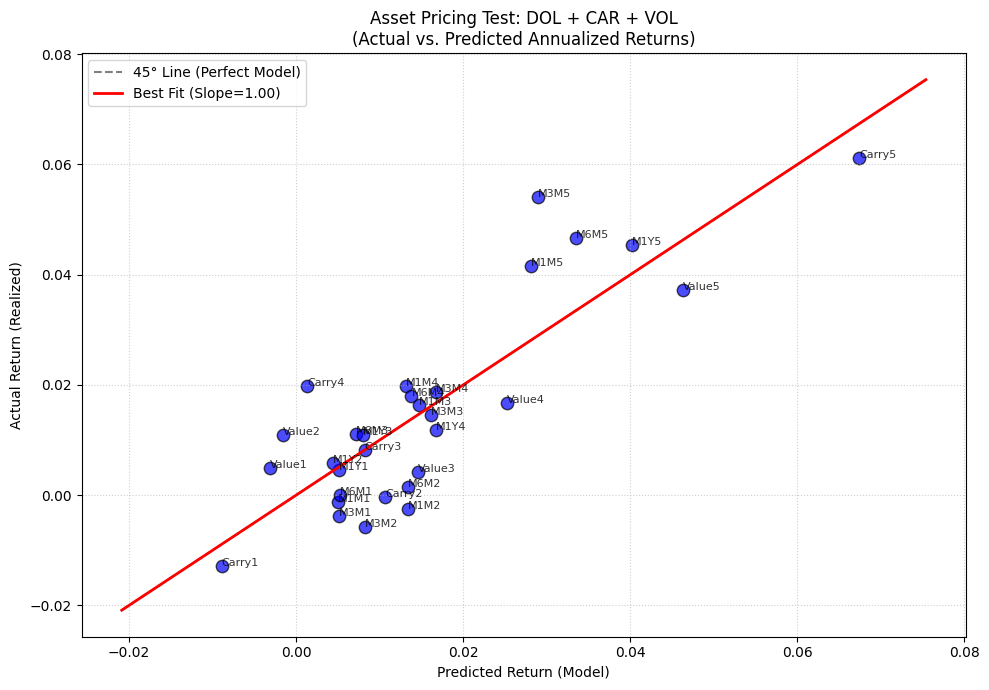

Step 4 Complete. If the points cluster around the red/dashed lines, your model works!


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("--- Step 4: Visualization (Actual vs. Predicted) ---")

# 1. Calculate Actual Average Returns (Annualized)
avg_ret_actual = test_assets.mean() * 12

# 2. Calculate Predicted Returns (Annualized)
# Check which factors are available in your betas
risk_factors_only = [c for c in ['DOL', 'CAR', 'VOL'] if c in betas.columns]

# Calculate component: Beta * Lambda
# We rely on 'prices_of_risk' from Step 3 and 'betas' from Step 2
risk_premium_component = np.dot(
    betas[risk_factors_only], prices_of_risk[risk_factors_only])

# Add Intercept
predicted_returns = prices_of_risk['Intercept'] + risk_premium_component

# Convert to Series
predicted_returns = pd.Series(
    predicted_returns, index=test_assets.columns) * 12

# --- CRITICAL FIX: FORCE DATA TO FLOAT ---
# This fixes the "numpy.object_" error by ensuring everything is a pure number
predicted_returns = predicted_returns.astype(float)
avg_ret_actual = avg_ret_actual.astype(float)

# 3. Plotting
plt.figure(figsize=(10, 7))

# Scatter plot
plt.scatter(predicted_returns, avg_ret_actual,
            alpha=0.7, c='blue', edgecolors='k', s=80)

# Labels
for i, txt in enumerate(test_assets.columns):
    # Simplify label (e.g., "CAR_P5" -> "CAR5")
    label = txt.replace('_P', '').replace(
        'CAR', 'Carry').replace('VAL', 'Value')
    plt.annotate(
        label, (predicted_returns.iloc[i], avg_ret_actual.iloc[i]), fontsize=8, alpha=0.8)

# 4. Add Lines
# A. 45-Degree Line (Theoretical Perfect Fit)
mn = min(predicted_returns.min(), avg_ret_actual.min())
mx = max(predicted_returns.max(), avg_ret_actual.max())
buff = (mx - mn) * 0.1
lims = [mn - buff, mx + buff]
plt.plot(lims, lims, 'k--', alpha=0.5, label='45° Line (Perfect Model)')

# B. Best Fit Line (Actual Regression Line)
# Now this should work without error
m, b = np.polyfit(predicted_returns, avg_ret_actual, 1)
x_fit = np.linspace(lims[0], lims[1], 100)
plt.plot(x_fit, m*x_fit + b, 'r-', linewidth=2,
         label=f'Best Fit (Slope={m:.2f})')

# Formatting
plt.title(
    'Asset Pricing Test: DOL + CAR + VOL\n(Actual vs. Predicted Annualized Returns)')
plt.xlabel('Predicted Return (Model)')
plt.ylabel('Actual Return (Realized)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("Step 4 Complete. If the points cluster around the red/dashed lines, your model works!")

In [10]:
# Calculate the difference (Alpha)
pricing_errors = avg_ret_actual - predicted_returns

print("\n--- Pricing Errors (Alphas) ---")
print(pricing_errors.describe())
print("\nFirst 5 Alphas:")
print(pricing_errors.head())


--- Pricing Errors (Alphas) ---
count    3.000000e+01
mean     4.076600e-17
std      9.966540e-03
min     -1.590321e-02
25%     -7.972582e-03
50%     -3.031085e-04
75%      5.025050e-03
max      2.517736e-02
dtype: float64

First 5 Alphas:
CAR_P1   -0.003937
CAR_P2   -0.010961
CAR_P3   -0.000028
CAR_P4    0.018432
CAR_P5   -0.006181
dtype: float64


In [11]:
# 1. Re-calculate inputs from scratch
actual_means = test_assets.mean() * 12
betas_check = betas[['DOL', 'CAR', 'VOL']].astype(float)
lambdas_check = prices_of_risk[['DOL', 'CAR', 'VOL']].astype(float)
intercept = float(prices_of_risk['Intercept'])

# 2. Manual Prediction
# Pred = Intercept + (Beta_DOL * Lambda_DOL) + ...
pred_manual = intercept + betas_check.dot(lambdas_check)
pred_manual = pred_manual * 12

# 3. Check Correlation
correlation = np.corrcoef(pred_manual, actual_means)[0, 1]
print(f"Correlation between Actual and Predicted: {correlation:.4f}")
# If 1.0000 -> Suspicious.
# If ~0.60 to 0.90 -> Good model.

Correlation between Actual and Predicted: 0.8463


In [12]:
stats_df.T.sort_values(by='Sharpe').index

Index(['Top-3', 'Mean', 'Sharpe', 'Max Return', 'Min Variance', 'Naive',
       'Downside Parity', 'Volatility'],
      dtype='object')